## Focal Loss

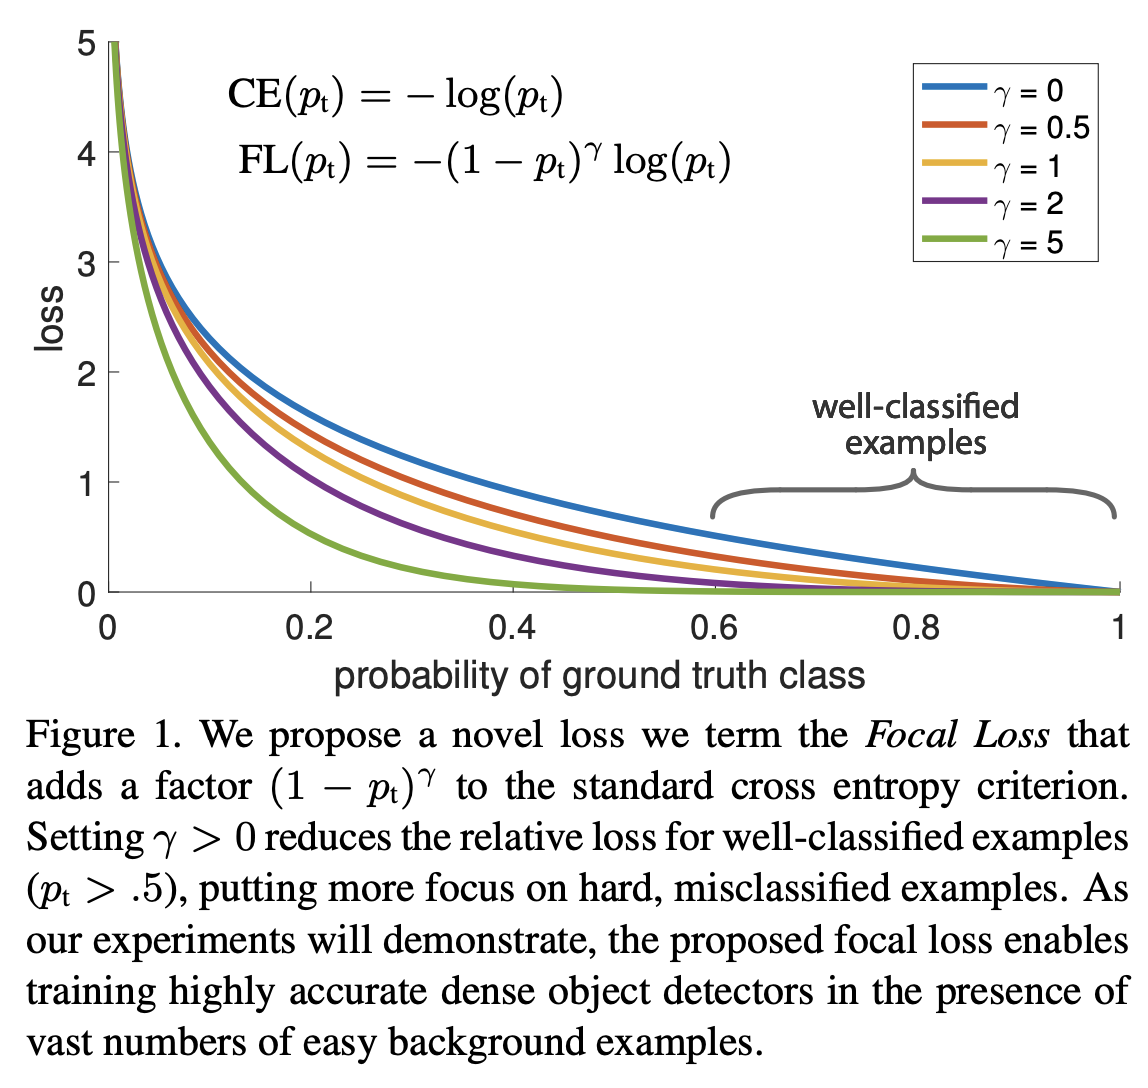

1. Positive examples: Target Class or foreground information such as ground-truths.
2. Negative examples: Non-Target Class or background information such as anchors whose IoU with ground-truths is less than a given threshold.
3. Easy positives/negatives: Samples classified as positive/negative examples.
4. Hard positives/negatives: Samples misclassified as negative/positive examples.

#### Class Imbalance Problem

- This is observed when information related to one class in a dataset or mini-batches used in training is over-represented than the other classes.
- Training a network on an imbalanced dataset will make the network biased towards learning more representations of the data-dominated class and other classes will be underlooked.
- In the case of Object Detection, two confidence values are predicted. One is Objectness score(Whether an object is present in a box or not) and the other is Class score(To which class detected object belong to).
- So it becomes important to maintain a balanced state between foreground-background and foreground-foreground classes while training. If not handled, former creates a box confidence errors(Whether or not an object is present)and the latter creates class confidence errors(If an object is present in the box, then which class does it represent) during training.


#### Story
Let’s consider a scenario of a soccer match. You are seeing your favorite rivalry of Real Madrid vs Barcelona on television. The stadium is fully packed with the audience chanting for their respective teams with a total of 70,000 people. Suddenly Real Madrid scores and whole stadium bursts will the chants of “Goaalll..!!”. No one can hear anything but chants, chants, and chants. 3 commentators are analyzing the match that these telecast reporters want to show on the TV. So what they do to? They give more importance to the commentary and give less weight to the chants so that people watching on television can listen to the commentary and live match analysis. Yes, you will hear the chants while watching but, commentary voice will get more amplified. Remember this analogical example for now.We will see how this example relates to Focal Loss

Let’s devise the equations of Focal Loss step-by-step:

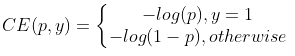

Simplifying this we can write the above as

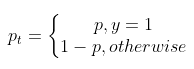

and

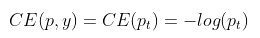

α term is added to the above to handle the class imbalance problem. It is a hyperparameter that can be used with the CE loss function for cross-validation. α_t is a weighted term whose value is α for positive(foreground) class and 1-α for negative(background) class.

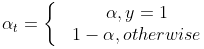

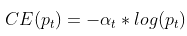

The above equation only handles and controls the weight of positive and negative samples, but it doesn’t take into consideration easy and hard samples. So finally, Focal Loss was designed in such a way that it handles both the mentioned conditions. Two forms of Focal Loss are given below.

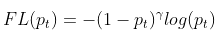


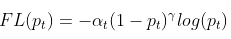



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision



In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super (FocalLoss, self).__init__()
        self.gamma= gamma
        self.alpha= alpha

        if isinstance(alpha, (float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.size_average= size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()





In [ ]:
# Test
import os,sys,random,time
import argparse
start_time = time.time()
maxe = 0
for i in range(1000):
    x = torch.rand(12800,2)*random.randint(1,10)
    x = Variable(x.cuda())
    l = torch.rand(12800).ge(0.1).long()
    l = Variable(l.cuda())

    output0 = FocalLoss(gamma=0)(x,l)
    output1 = nn.CrossEntropyLoss()(x,l)

    a = output0.item()
    b = output1.item()
    if abs(a-b)>maxe: maxe = abs(a-b)
print('time:',time.time()-start_time,'max_error:',maxe)


start_time = time.time()
maxe = 0
for i in range(100):
    x = torch.rand(128,1000,8,4)*random.randint(1,10)
    x = Variable(x.cuda())
    l = torch.rand(128,8,4)*1000    # 1000 is classes_num
    l = l.long()
    l = Variable(l.cuda())

    output0 = FocalLoss(gamma=0)(x,l)
    output1 = nn.NLLLoss2d()(F.log_softmax(x),l)
    a = output0.item()
    b = output1.item()
    if abs(a-b)>maxe: maxe = abs(a-b)
print('time:',time.time()-start_time,'max_error:',maxe)

In [38]:
import torch
import torch.nn.functional as F

def focal_loss_binary(predictions, labels, alpha=0.25, gamma=2.0):
    """
    Args:
        predictions: Tensor of shape (512, 1024) - Predicted logits for each pixel.
        labels: Tensor of shape (512, 1024) - Ground truth labels (0 or 1).
        alpha: Weighting factor for the rare class.
        gamma: Focusing parameter to reduce the relative loss for well-classified examples.

    Returns:
        loss: Computed focal loss for the input.
    """
    # Convert predictions to probabilities using sigmoid
    probs = torch.sigmoid(predictions)

    # Binary Cross Entropy loss for each pixel
    bce_loss = F.binary_cross_entropy(probs, labels.float(), reduction='none')

    # Compute the focal loss
    pt = torch.where(labels == 1, probs, 1 - probs)  # pt is p_t
    focal_weight = (alpha * labels + (1 - alpha) * (1 - labels)) * (1 - pt).pow(gamma)

    loss = focal_weight * bce_loss
    return loss.mean()

# Example usage
# Assuming you have predictions, labels as input tensors
predictions = torch.randn((512, 1024), requires_grad=True)  # Replace with your prediction tensor
labels = torch.randint(0, 2, (512, 1024)).float()           # Replace with your label tensor
print(predictions)
print(labels)
# Calculate the focal loss
loss = focal_loss_binary(predictions, labels)

print("Focal Loss:", loss.item())

tensor([[ 0.5840,  0.2947, -0.0426,  ..., -1.1872, -0.4848, -0.3896],
        [-0.4196, -0.5618, -1.1387,  ..., -0.7656, -1.0740,  0.2025],
        [-0.4324, -0.1367,  0.2867,  ..., -2.1797, -0.0896,  0.1638],
        ...,
        [ 1.7233, -1.4572,  0.5817,  ...,  0.8899,  1.4038, -0.8426],
        [-0.8766, -0.7344,  0.4379,  ..., -1.1819, -0.4254,  1.2659],
        [ 0.5665,  1.4544,  0.3829,  ..., -0.6910, -0.8436, -1.5133]],
       requires_grad=True)
tensor([[0., 1., 0.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 0.,  ..., 0., 1., 1.],
        [1., 1., 0.,  ..., 0., 1., 1.],
        [0., 0., 1.,  ..., 0., 1., 1.]])
Focal Loss: 0.1730373501777649


In [41]:
import torch
import torch.nn.functional as F

def focal_loss_multiclass(predictions, labels, alpha=0.25, gamma=2.0):
    """
    Args:
        predictions: Tensor of shape (N, C, H, W) - Predicted logits for each class at each pixel.
        labels: Tensor of shape (N, H, W) - Ground truth labels with class indices (0 to C-1).
        alpha: Weighting factor for each class (either a scalar or a tensor of shape (C,)).
        gamma: Focusing parameter to reduce the relative loss for well-classified examples.

    Returns:
        loss: Computed focal loss for the input.
    """
    # Convert predictions to probabilities using softmax across the channel dimension (class dimension)
    probs = F.softmax(predictions, dim=1)  # Shape: (N, C, H, W)

    # Convert labels to one-hot encoding to match the shape of predictions
    labels_one_hot = F.one_hot(labels, num_classes=predictions.shape[1])  # Shape: (N, H, W, C)
    labels_one_hot = labels_one_hot.permute(0, 3, 1, 2)  # Shape: (N, C, H, W)

    # Compute the cross-entropy loss
    ce_loss = F.cross_entropy(predictions, labels, reduction='none')  # Shape: (N, H, W)

    # Compute the focal loss
    pt = torch.sum(probs * labels_one_hot, dim=1)  # Shape: (N, H, W)

    # Ensure alpha is broadcast correctly
    if isinstance(alpha, (float, int)):
        alpha_factor = alpha
    else:
        alpha = alpha.to(predictions.device)
        alpha_factor = torch.sum(alpha[None, :, None, None] * labels_one_hot, dim=1)  # Shape: (N, H, W)

    focal_weight = alpha_factor * (1 - pt).pow(gamma)

    loss = focal_weight * ce_loss
    return loss.mean()

# Example usage
N, C, H, W = 10, 5, 512, 1024  # Example dimensions (batch size N, number of classes C, height H, width W)
predictions = torch.randn(N, C, H, W, requires_grad=True)  # Replace with your prediction tensor
labels = torch.randint(0, C, (N, H, W))                    # Replace with your label tensor

# If alpha is a scalar (applies equally to all classes)
alpha = 0.25

# If alpha is a vector (different weight for each class)
# alpha = torch.tensor([0.25, 0.25, 0.25, 0.25, 0.25])  # Adjust according to your number of classes

# Calculate the focal loss
loss = focal_loss_multiclass(predictions, labels, alpha=alpha)

print("Focal Loss:", loss.item())

Focal Loss: 0.37829461693763733


In [22]:
import numpy as np
import matplotlib.pyplot as plt
# utility functions to get Cityscapes Pytorch dataset and dataloaders
from utils import get_cs_datasets

data= get_cs_datasets(rootDir='data')
sample_image, sample_label = data[0]
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

Input shape = torch.Size([3, 512, 1024]), output label shape = torch.Size([512, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


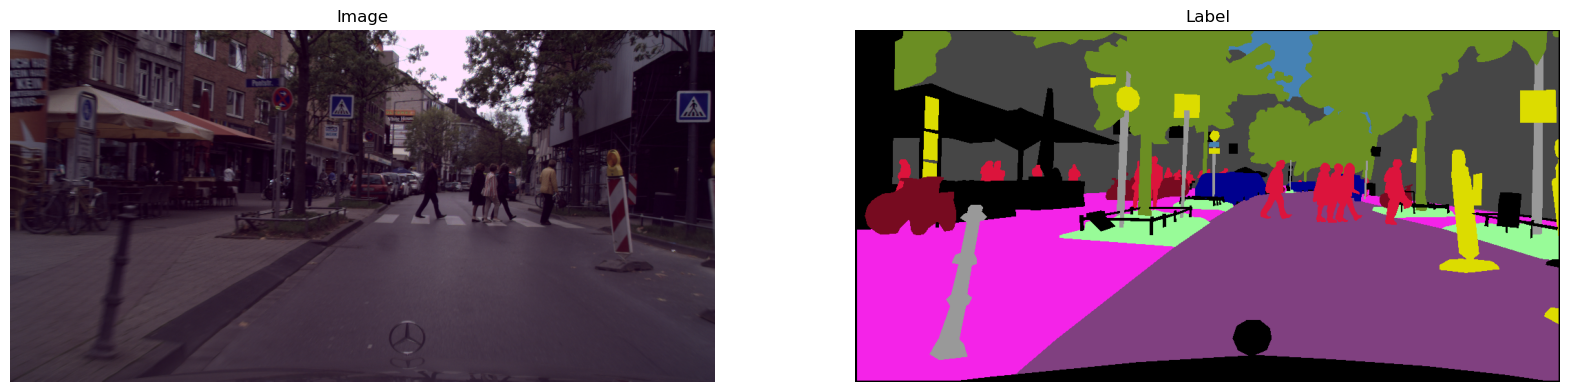

In [23]:
from utils import inverse_transform
from utils import train_id_to_color as cs_train_id_to_color

rgb_image, label = data[1]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(cs_train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

In [27]:
label_t= torch.from_numpy(label)
print(label_t)
loss = focal_loss_multiclass(label_t.float() , label_t.float() )
print("Focal Loss:", loss.item())

tensor([[19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19],
        ...,
        [19, 19, 19,  ...,  0, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19],
        [19, 19, 19,  ..., 19, 19, 19]])


RuntimeError: all elements of target should be between 0 and 1

In [20]:
loss= torchvision.ops.sigmoid_focal_loss(x,l)
print(loss)
loss_2= torchvision.ops.focal_loss(x,l)
print(loss_2)

ValueError: Target size (torch.Size([128, 8, 4])) must be the same as input size (torch.Size([128, 1000, 8, 4]))